## Libraries and data

In [60]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
import io
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from tqdm import tqdm

In [2]:
# Specify the URL of the data tile
url = (
    'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/'
    'Hansen_GFC-2019-v1.7_treecover2000_50N_090W.tif')

In [3]:
# Load the data into a NumPy array. It might take a minute to
# download the data since these data tiles are large.
Image.MAX_IMAGE_PIXELS = None
data_tile = np.array(
    Image.open(
        io.BytesIO(
            requests.get(url).content)))

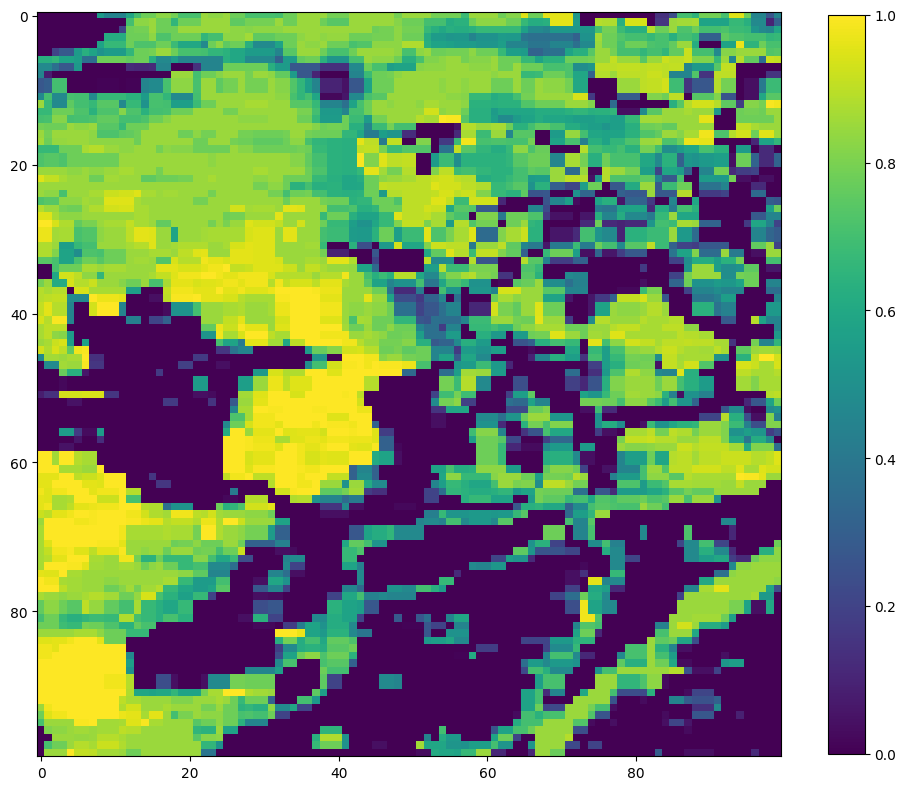

In [63]:
# Plot a 2000 x 2000 part of the whole data tile. You can plot all
# of it but it takes a long time since the data tile is so large.
forest = data_tile[400:500,400:500]/100
plt.figure(figsize=(12, 12))
plt.imshow(forest, cmap='viridis')
plt.colorbar(shrink=0.8)
plt.show()

## Classes and Functions

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class ForestFire:
    def __init__(self, forest, wind_direction=(1, 0), wind_strength=0.8, ignition_prob=0.1, percolation_threshold=0.389, block_y=None, block_x=None):
        """
        Initialize the ForestFire simulation.

        Parameters:
        - forest: 2D array representing initial tree density in the forest.
        - wind_direction: Tuple representing the wind direction.
        - wind_strength: Wind strength affecting fire spread.
        - ignition_prob: Probability of ignition at a cell.
        - percolation_threshold: Tree density threshold for fire spread.
        - block_y, block_x: Coordinates of a blocked cell (optional).
        """
        self.tree_density_grid = forest
        self.grid_size = self.tree_density_grid.shape
        self.grid_states = np.zeros(self.tree_density_grid.shape)
        self.wind_direction = wind_direction
        self.wind_strength = wind_strength
        self.ignition_prob = ignition_prob
        self.percolation_threshold = percolation_threshold
        self.done = True
        self.step_counter = 0
        self.block_y = block_y
        self.block_x = block_x

    def calculate_ignition_prob(self, dx, dy):
        """
        Calculate ignition probability based on wind direction and strength.

        Parameters:
        - dx, dy: Wind direction components.

        Returns:
        - Ignition probability.
        """
        dot_product = np.dot(self.wind_direction, (dx, dy)) #if dot product is 1, then it is a neighboring cell of wind direction
        if self.wind_direction != (dx, dy):
            if dot_product == 1:
                return self.ignition_prob + (1 - self.ignition_prob) * self.wind_strength * np.sin(np.radians(45))
            else:
                return self.ignition_prob
        else:
            return self.ignition_prob + (1 - self.ignition_prob) * self.wind_strength

    def start_fire(self, anim=False, x=None, y=None):
        """
        Start a fire at a given location or a random location if none provided.

        Parameters:
        - anim: Flag to enable animation (optional).
        - x, y: Coordinates of the starting fire location (optional).
        """
        if x is None or y is None:
            x, y = np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1])
        self.grid_states[x, y] = 1  # 1 represents burning
        if anim:
            self.figure, self.axes = plt.subplots()

    def update(self):
        """
        Run the fire spread simulation for a given number of steps.
        """
        new_states = self.grid_states.copy()
        for x in range(self.grid_size[0]):
            for y in range(self.grid_size[1]):
                if self.grid_states[x, y] == 1:  # If the cell is burning
                    # Spread the fire based on tree density and wind
                    for dx in range(-1, 2):
                        for dy in range(-1, 2):
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < self.grid_size[0] and 0 <= ny < self.grid_size[1]:
                                if self.grid_states[nx, ny] == 0:
                                    if self.tree_density_grid[x, y] > self.percolation_threshold and y != self.block_y and x != self.block_x:
                                        # considering firebreaks here
                                        spread_prob = self.calculate_igniton_prob(dx, dy)
                                        if np.random.rand() < spread_prob:
                                            new_states[nx, ny] = 1
                    new_states[x, y] = 2  # The cell is now burnt
                    self.tree_density_grid[x, y] = 0
                if np.all(self.grid_states != 1):
                    self.done = False
        self.grid_states = new_states
        self.step_counter += 1

    def visualize(self):
        """
        Visualize the current state of the grid.
        """
        plt.figure(figsize=(5, 5))
        plt.imshow(self.tree_density_grid, cmap='viridis')
        plt.colorbar(shrink=0.8, ticks=[0, 1])
        plt.title(f"Forest Fire Simulation after step {self.step_counter}")
        plt.show()

    def observe(self):
        """
        Observe the current state of the grid for animation.

        Returns:
        - Plot object for animation.
        """
        plot = self.axes.imshow(self.tree_density_grid, cmap='viridis')
        self.axes.set_title(f'State at step {self.step_counter}')
        return plot


In [64]:
def visualizer_params(param_name, params, num_steps=30):
    """
    Visualize the ForestFire simulation for different parameter values.

    Parameters:
    - param_name: Name of the parameter to vary ('wind_direction', 'ignition_prob', 'wind_strength').
    - params: List of parameter values to test.
    - num_steps: Number of simulation steps to run.

    Returns:
    - None
    """
    for i in params:
        forest = np.ones((100, 100))
        if param_name == 'wind_direction':
            simulation = ForestFire(forest, wind_direction=i)
        elif param_name == 'ignition_prob':
            simulation = ForestFire(forest, ignition_prob=i)
        elif param_name == 'wind_strength':
            simulation = ForestFire(forest, wind_strength=i)

        simulation.start_fire(x=50, y=50)

        for _ in range(num_steps):
            simulation.update()

        simulation.visualize()
        print(f'{param_name}: {i}')

    return None

def make_animation(sim, total_frames, steps_per_frame=1, interval=100):
    """
    Create an animation of ForestFire simulation.

    Parameters:
    - sim: ForestFire simulation object.
    - total_frames: Total number of frames in the animation.
    - steps_per_frame: Number of simulation steps per frame.
    - interval: Time interval between frames in milliseconds.

    Returns:
    - HTML animation output.
    """
    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.update()
        progress_bar.update(1)
        return [sim.observe()]

    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output

def simulator(y_block, x_block, trials=100):
    """
    Run multiple ForestFire simulations with random parameters and a specified firebreaks.

    Parameters:
    - y_block, x_block: Coordinates of the blocked cell.
    - trials: Number of simulations to run.

    Returns:
    - List of result grids from simulations.
    """
    result_grids = []
    wind_directions = [(-1, -1), (-1, 0), (0, -1), (0, 1), (1, 0), (1, 1), (1, -1), (-1, 1)]
    progress_bar = tqdm(total=trials)

    for _ in range(trials):
        forest = data_tile[400:500, 400:500] / 100
        simulation = ForestFire(forest, wind_directions[np.random.randint(0, 8)], np.random.rand(), np.random.rand(),
                                block_y=y_block, block_x=x_block)
        simulation.start_fire()
        while simulation.done:
            simulation.update()
        result_grids.append(simulation.tree_density_grid)
        progress_bar.update(1)

    return result_grids

def burn_freq(result_grids):
    """
    Calculate the frequency of burns in the ForestFire simulations.

    Parameters:
    - result_grids: List of result grids from simulations.

    Returns:
    - 2D array representing the number of burns at each cell.
    """
    number_of_burns_grid = np.array([[0] * 100] * 100)
    forest = data_tile[400:500, 400:500] / 100

    for u in range(100):
        for v in range(100):
            for i in range(100):
                if result_grids[i][u][v] != forest[u][v]:
                    number_of_burns_grid[u][v] += 1

    return number_of_burns_grid

def hotmap_plotter(result_grids):
    """
    Plot a heatmap of the ForestFire simulation results.

    Parameters:
    - result_grids: List of result grids from simulations.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(result_grids, cmap='hot')
    plt.colorbar(shrink=0.8)
    plt.title("Forest Fire Simulation")
    plt.show()


## Simulations

In [ ]:
wind_directions = [(-1,-1), (-1,0), (0,-1), (0,1), (1,0), (1,1), (1,-1), (-1,1)]
wind_strengths = [0.1, 0.3, 0.5, 0.7, 1]
ignition_probs = [0.1, 0.3, 0.5, 0.7, 1]
visualizer_params('wind_direction',wind_directions)
visualizer_params('ignition_prob',ignition_probs)
visualizer_params('wind_strength',wind_strengths)


In [61]:
forest = data_tile[400:500,400:500]/100
simulation = ForestFire(forest)
simulation.start_fire(True, 20,50)
make_animation(simulation, total_frames = 60, steps_per_frame=1)

100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


<Figure size 640x480 with 0 Axes>

### Simulating with different firebreaks for 100 trials each.

In [ ]:
result_grids = simulator(None, None)

In [ ]:
result_grids_x13_block = simulator(None, 13)

In [ ]:
result_grids_y37_block = simulator(37, None)

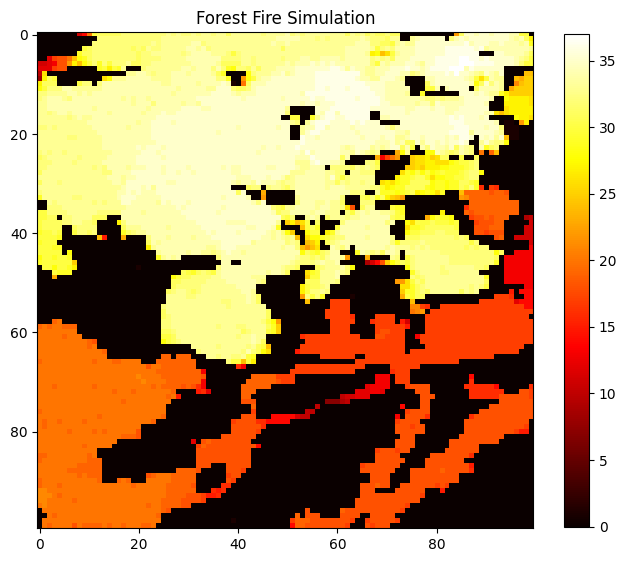

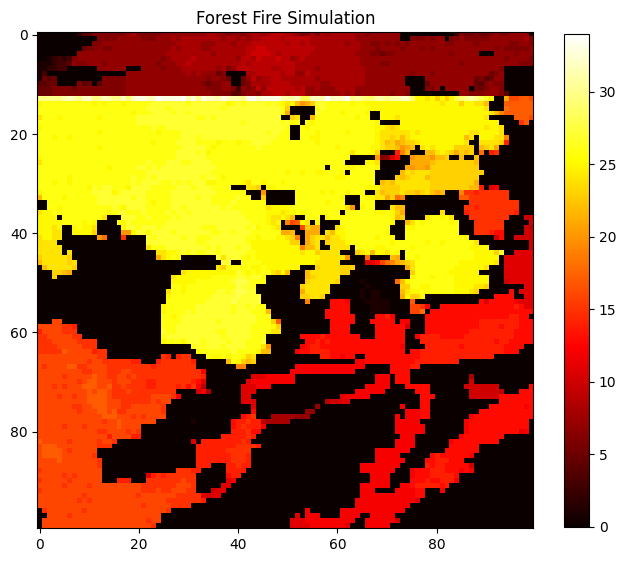

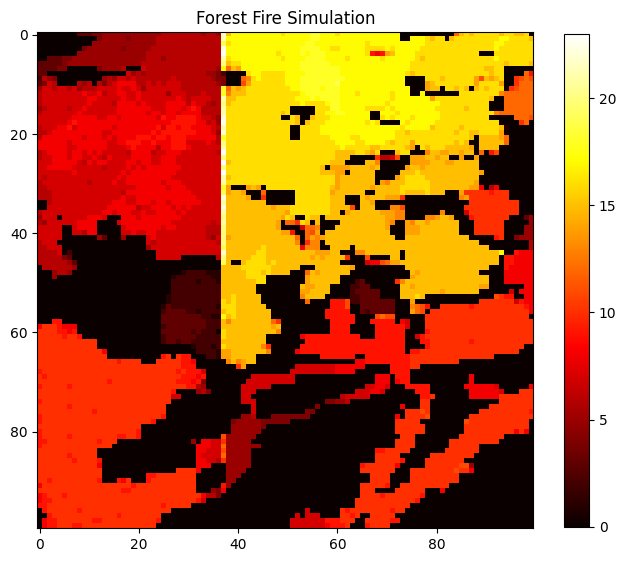

In [67]:
hotmap_plotter(burn_freq(result_grids))
hotmap_plotter(burn_freq(result_grids_x13_block))
hotmap_plotter(burn_freq(result_grids_y37_block))

## Histograms

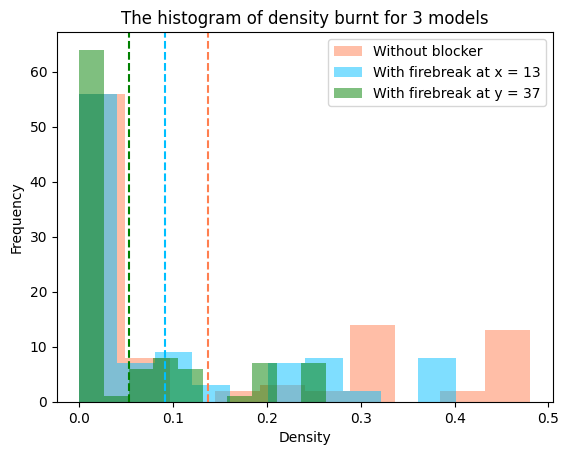

In [78]:
initial_density = np.mean(forest)

density_burned = initial_density - np.mean(result_grids, axis = (1,2))
density_burned_x13_block  = initial_density - np.mean(result_grids_x13_block, axis = (1,2))
density_burned_y37_block = initial_density - np.mean(result_grids_y37_block, axis = (1,2))


plt.hist(density_burned, color = 'coral', label = 'Without blocker', alpha = 0.5)
plt.hist(density_burned_x13_block, color = 'deepskyblue', label = 'With firebreak at x = 13', alpha = 0.5)
plt.hist(density_burned_y37_block, color = 'green', label = 'With firebreak at y = 37', alpha = 0.5)


plt.axvline(np.mean(density_burned), linestyle = '--', color = 'coral')
plt.axvline(np.mean(density_burned_x13_block), linestyle = '--', color = 'deepskyblue')
plt.axvline(np.mean(density_burned_y37_block), linestyle = '--', color = 'green')

plt.title('The histogram of density burnt for 3 models')
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [79]:
print(f'Mean of no firebreak model {np.mean(density_burned)}\n'
      f'Mean of horizontal firebreak model {np.mean(density_burned_x13_block)}\n'
      f'Mean of vertical firebreak model {np.mean(density_burned_y37_block)}\n')

Mean of no firebreak model 0.13684750999999998
Mean of horizontal firebreak model 0.09118261999999999
Mean of vertical firebreak model 0.05310705999999999



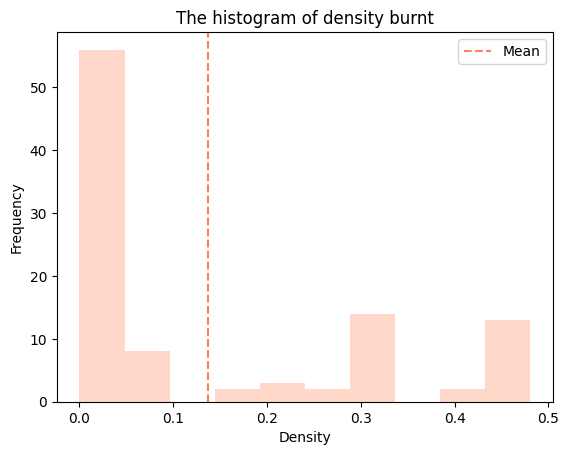

In [59]:
plt.hist(density_burned, color = 'coral', alpha = 0.3)
plt.axvline(np.mean(density_burned), linestyle = '--', color = 'coral', label = 'Mean')
plt.title('The histogram of density burnt')
plt.ylabel('Frequency')
plt.xlabel('Density')
plt.legend()
plt.show()

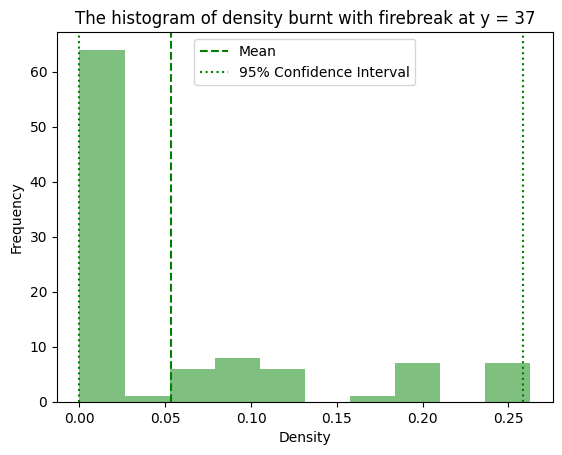

In [80]:
plt.hist(density_burned_y37_block, color = 'green', alpha = 0.5)
plt.axvline(np.mean(density_burned_y37_block), linestyle = '--', color = 'green', label = 'Mean')

plt.axvline(np.percentile(density_burned_y37_block, 97.5), linestyle = ':', color = 'green', label = '95% Confidence Interval')
plt.axvline(np.percentile(density_burned_y37_block, 2.5), linestyle = ':', color = 'green')

plt.title('The histogram of density burnt with firebreak at y = 37')
plt.ylabel('Frequency')
plt.xlabel('Density')
plt.legend()
plt.show()